Formation OpenClassrooms DS-IML

**Projet 2**

Par **Marc Lefèvre**, <marc.lefevre@noos.fr>

## 5ème Partie

# Words Processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk

from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer

Récupération des données et élimination des données dont le **product_name** n'est pas renseigné.

In [2]:
df = pd.read_csv("Data/df_mot.csv")
df = df[df["product_name"].notnull()]

## WordCloud & TopWords

Traitement et exploration

Création d'une colo **words** qui regroupe **product_name** et **brands**.<br>On additionne des colonnes converties en **str**.<br>Comme **brands** est peu renseigné, on remplit ses valeurs vides avec une **str** vide.

In [3]:
df["words"] = df["product_name"].astype('str') + " " + df["brands"].fillna("").astype('str')

Dans notre colonne **words** nous ne voulons garder que les mots composés de **lettres** (élimination des chiffres et de ce qui contient des chiffres, éliminations de la ponctuation, de caractères spéciaux...).<br>Dans ce but nous allons utiliser un objet **RegexpTokenizer** du module **nltk**, qui, paramétré avec une **expression régulière** adéquate, effectuera le nettoyage lors de la **tokenisation**.<br>Pour rappel, nous avons déjà, précédemment, converti nos variables texte ne caractères minuscules.

In [4]:
tokenizer = nltk.RegexpTokenizer('[a-z]\w+')

Après la **tokenisation**, nous éliminerons de nos données les **stopwords** recensés dans la liste de **stopwords** français du module **nltk**. 

In [5]:
sw = stopwords.words("french")

Pour les besoins de notre petite exploration préliminaire, nous créons une variable texte **corpus** regroupant tous les mots de nos données séparés par des *espaces*.<br>On **tokenise** ensuite la liste puis on lui enlève ses **stopwords**

In [6]:
corpus = " ".join(df["words"])
corpus = tokenizer.tokenize(corpus)
corpus = [mot for mot in corpus if mot not in sw]

Afin d'afficher notre **word cloud**, on doit retransformer notre **corpus** en texte (la **tokenisation** retourne une **liste**).

In [12]:
corpus_wc = " ".join(corpus)

Affichage du **word cloud** avec **bigrammes**

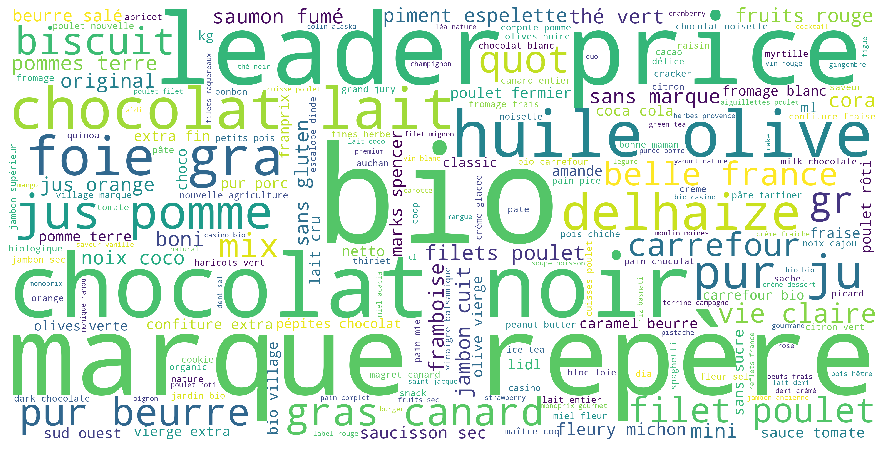

In [22]:
words_cloud_bi = WordCloud(background_color = 'white', height = 2000, width = 4000, 
                        collocations = True).generate(corpus_wc)
plt.figure(figsize = (16,8))
plt.imshow(words_cloud_bi)
plt.axis('off')
plt.show()

Affichage du **word cloud** avec seulement des **unigrammes**

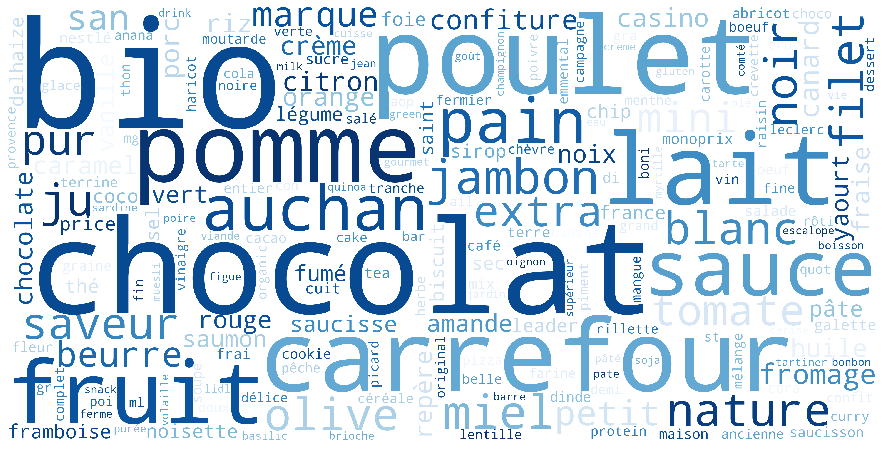

In [23]:
words_cloud_un = WordCloud(background_color = 'white', height = 2000, width = 4000, 
                           collocations = False, colormap = "Blues").generate(corpus_wc)
plt.figure(figsize = (16,8))
plt.imshow(words_cloud_un)
plt.axis('off')
plt.show()

Maintenant, penchons nous sur la **distribution de fréquence** des mots dans notrre **corpus**, et recherchons les mots les plus et les moins présents. Dans ce but, on utilise la fonction **FreqDist** de **nltk**.

In [29]:
fdist = FreqDist(corpus)
top_words = fdist.most_common(20)
print(top_words)

[('bio', 35193), ('chocolat', 25585), ('poulet', 17185), ('carrefour', 14825), ('lait', 14484), ('sauce', 12427), ('auchan', 11969), ('jambon', 10919), ('miel', 10178), ('pain', 9796), ('nature', 9567), ('noir', 9299), ('jus', 9283), ('fruits', 9220), ('pomme', 9088), ('extra', 8814), ('pur', 8497), ('marque', 8478), ('blanc', 8423), ('beurre', 8336)]


Affichons ces mots dans un graph.

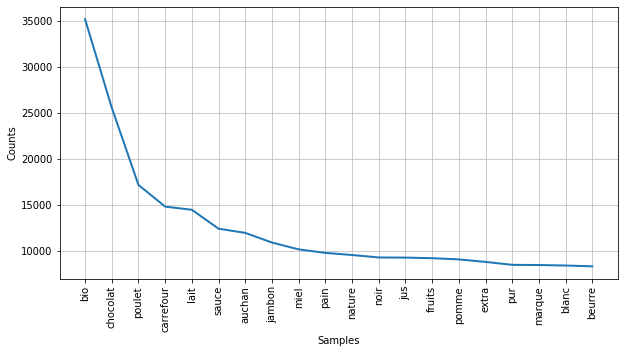

In [30]:
plt.figure(figsize = (10, 5))
fdist.plot(20)
plt.show()

On retrouve bien les mots qui prennent le plus deplace dans le secnond **word cloud**.<br>Pour les mots les **moins** utilisés, on récupère la liste depuis notre distribution, et on en affiche la **fin**.

In [32]:
liste_totale = fdist.most_common()
print(liste_totale[-20:])

[('boulaire', 1), ('tapettes', 1), ('sud_', 1), ('spghetti', 1), ('gaspi', 1), ('pannés', 1), ('cappelbert', 1), ('citronvert', 1), ('grzines', 1), ('codido', 1), ('yamou', 1), ('foir', 1), ('nergisé', 1), ('quédate', 1), ('primora', 1), ('brund', 1), ('coutance', 1), ('intregrale', 1), ('natouze', 1), ('tarczynski', 1)]


## Preparation des données pour le moteur de<br>recommandations

Nous allons créer une nouvelle colonne **tokens** à notre dataset.<br>Celle ci contiendra les valeurs de **words** mais **tokenisées**, sans **stopwords**, et également **stemmerisée**.<br>On commence par la **tokenisation**.

In [7]:
df["tokens"] = df["words"].map(tokenizer.tokenize)

On se sépare des **stopwords** grâce à la petite fonction suivante, qui en plus passera notre variable par un processus de **stemming** avant de la transformer à nouveau en **str** (car la **tokenisation** retourne une liste...).

In [8]:
stemmer = FrenchStemmer()

def sw_stem_str(l):
    
    for elt in l:
        if elt in sw :
            l.remove(elt)

    li = [stemmer.stem(w) for w in l]        
    
    ligne = " ".join(li)
    return ligne

df["tokens"] = df["tokens"].map(sw_stem_str)

Maintenant, nous allons créer une **matrice** en vectorisant notre colonne **tokens** grâce à **TfidfVectorizer**. Cette matrice nous servira dans la prochaine étape pour calculer les résultats de requêtes.

In [9]:
vect = TfidfVectorizer(analyzer = "word")
vect.fit(df["tokens"])
matrix = vect.transform(df["tokens"])

Une fois cette matrice crée, nous pouvons éliminer les colonnes **words** et **tokens** du dataset, qui ne nous servent plus à rien.

In [10]:
df = df.drop(["words", "tokens"], axis = 1)

Nous allons pouvoir passer maintenant au **moteur de recommandation** lui-même.<br>Sauvegardons juste les éléments dont nous auront besoin.

In [12]:
df.to_csv("Data/df.csv", index = False)

pickle1 = open("Data/vect.pickle", "wb")
pickle.dump(vect, pickle1)
pickle1.close()

pickle2 = open("Data/matrix.pickle", "wb")
pickle.dump(matrix, pickle2)
pickle2.close()

pickle3 = open("Data/tokenizer.pickle", "wb")
pickle.dump(tokenizer, pickle3)
pickle3.close()

Fin de la **5ème partie**.